In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Objective**:

The overall goal of our project is to find a way of identifying fraudulent healthcare insurance providers.

Significance of this Project:

According to the Centers for Medicare & Medicaid Services (CMS), in 2020, 6.27% of Medicare expenses were found to improper payments/fraudulent in nature. Although this percentage may not seem too worrying, these frauduluent claims still amount to about 60 billion dollars in losses, which is a significant amount of money that can be better allocated to help more people, especially during the ongoing pandemic.

On a more miscroscopic level, beyond the economic damage that they have on the Medicare program, frauduluent providers also target vulnerable individuals by charging them for a more complex/expensive service than was actually provided.

In our project, we will look at the variables based on individual claim details and individual beneficiary details in past healthcare insurance claims to find signals that highlight fraudulent activity:

**Data**

Some important notes about the data source we are using:
1. Last updated in 2019
2. Due to privacy reasons, a lot of the information is coded (eg. each state is reflected by a number, same with race, diagnosis, etc)
3. In the training set, the potential fraudulent column is determined by the provider ID. In other words, if a provider is determined to be fraudulent, all of their claims are labelled as fraudulent, even if some of their claims might be honest in nature. This distinction is essential in our project because we are trying to find other fraudulent providers and to do so, we must look at patterns in a fraudulent provider's overall activity, rather than just zeroing on specific fraudulent claims.

For instance, if a fraudulent provider has 99% honest claims and 1% fraudulent claim, it will be hard for us to point them out if we focus on just their fraudulent claims. By analyze their activity as a whole (as we are doing in this project), we are able to look past any "masking" behavior used to hide fraudulent activity.

In [ ]:
import os

In [ ]:
import pandas as pd

# Load Train Dataset

Train=pd.read_csv("dataset/Train.csv")
Train_Beneficiarydata=pd.read_csv("dataset/Train_Beneficiarydata.csv")
Train_Inpatientdata=pd.read_csv("dataset/Train_Inpatientdata.csv")
Train_Outpatientdata=pd.read_csv("dataset/Train_Outpatientdata.csv")

FileNotFoundError: ignored

In [ ]:
Train.shape

(5410, 2)

### Data Cleaning

In [ ]:
# Only one column has less 0.1%
Train_Beneficiarydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [ ]:
# In both In and Out patient data, ClmDiagnosis and ClmProcedure can be shortened to be treated as how many diagnosis and procedure each beneID has.
# OtherPhysician can be dropped due to around 90% null value
Train_Inpatientdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [ ]:
diag_columns = Train_Inpatientdata.columns[14:24]
proc_columns = Train_Inpatientdata.columns[24:]

Train_Inpatientdata['Diagnosis_count'] = Train_Inpatientdata.loc[:, diag_columns].notnull().sum(axis=1)
Train_Inpatientdata['Procedure_count'] = Train_Inpatientdata.loc[:, proc_columns].notnull().sum(axis=1)

In [ ]:
# Drop physicians related columns since we think they do not affect whether patients are fraud
Train_Inpatientdata.drop(columns=diag_columns, inplace=True)
Train_Inpatientdata.drop(columns=proc_columns, inplace=True)
Train_Inpatientdata.drop(columns=['AttendingPhysician','OperatingPhysician','OtherPhysician'], inplace=True)
Train_Inpatientdata.drop(columns=['AdmissionDt','DischargeDt','DiagnosisGroupCode'], inplace=True)
Train_Inpatientdata

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Diagnosis_count,Procedure_count
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,7866,1068.0,9,0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,6186,1068.0,3,1
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,29590,1068.0,6,0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,431,1068.0,9,1
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,78321,1068.0,9,1
...,...,...,...,...,...,...,...,...,...,...
40469,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,2859,1068.0,10,1
40470,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,79902,1068.0,9,1
40471,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,78605,1068.0,9,1
40472,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,7802,1068.0,9,0


In [ ]:
Train_Outpatientdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [ ]:
Train_Outpatientdata['Diagnosis_count'] = Train_Outpatientdata.loc[:, diag_columns].notnull().sum(axis=1)
Train_Outpatientdata['Procedure_count'] = Train_Outpatientdata.loc[:, proc_columns].notnull().sum(axis=1)

In [ ]:
# Drop physicians related columns since we think they do not affect whether patients are fraud
Train_Outpatientdata.drop(columns=diag_columns, inplace=True)
Train_Outpatientdata.drop(columns=proc_columns, inplace=True)
Train_Outpatientdata.drop(columns=['AttendingPhysician','OperatingPhysician','OtherPhysician'], inplace=True)
Train_Outpatientdata

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Diagnosis_count,Procedure_count
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,0,56409,3,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,0,79380,1,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,0,NaN,1,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,0,NaN,1,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,0,71947,6,0
...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,0,NaN,3,0
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,0,NaN,3,0
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,0,NaN,2,0
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,0,NaN,0,0


### Data Merging

Merge inpatient and outpatient data and create dataset for all patients

In [ ]:
Train_Inpatientdata.columns, Train_Outpatientdata.columns

(Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
        'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
        'Diagnosis_count', 'Procedure_count'],
       dtype='object'),
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
        'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode',
        'Diagnosis_count', 'Procedure_count'],
       dtype='object'))

In [ ]:
# Combine In and Out patients into one df
Train_Allpatientdata = pd.concat([Train_Inpatientdata, Train_Outpatientdata])
Train_Allpatientdata.sort_values('Provider', inplace=True)
Train_Allpatientdata.reset_index(drop=True, inplace=True)
Train_Allpatientdata

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Diagnosis_count,Procedure_count
0,BENE130029,CLM168357,2009-01-31,2009-01-31,PRV51001,1000,NaN,0.0,2,0
1,BENE61975,CLM260292,2009-03-22,2009-03-22,PRV51001,60,NaN,0.0,2,0
2,BENE56354,CLM403535,2009-06-08,2009-06-08,PRV51001,100,78659,0.0,3,0
3,BENE152088,CLM37205,2009-02-06,2009-02-06,PRV51001,4000,80121,1068.0,6,1
4,BENE130029,CLM262535,2009-03-23,2009-03-23,PRV51001,90,NaN,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...
558206,BENE59602,CLM342554,2009-05-05,2009-05-05,PRV57763,20,NaN,0.0,1,0
558207,BENE53546,CLM231520,2009-03-06,2009-03-06,PRV57763,300,71945,0.0,1,0
558208,BENE117964,CLM604643,2009-09-29,2009-09-29,PRV57763,10,NaN,0.0,3,0
558209,BENE108637,CLM425758,2009-06-20,2009-06-20,PRV57763,50,NaN,0.0,1,0


Merge Benegiciary details to All Patients data

In [ ]:
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, left_on='BeneID', right_on='BeneID', how='inner')
Train_Allpatientdata.sort_values('Provider', inplace=True)
Train_Allpatientdata.reset_index(drop=True, inplace=True)
Train_Allpatientdata

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Diagnosis_count,Procedure_count,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE130029,CLM168357,2009-01-31,2009-01-31,PRV51001,1000,NaN,0.0,2,0,1927-03-01,NaN,2,1,0,1,660,12,12,1,1,2,2,1,2,1,1,2,2,1,7000,1068,4480,200
1,BENE32715,CLM272936,2009-03-29,2009-03-30,PRV51001,500,78902,0.0,6,0,1936-03-01,NaN,1,1,0,1,410,12,12,1,1,1,1,1,1,1,1,2,2,2,2020,1068,6700,2700
2,BENE86784,CLM119495,2009-01-04,2009-01-04,PRV51001,10,NaN,0.0,1,0,1934-01-01,NaN,2,1,0,1,440,12,12,1,2,2,2,2,2,1,1,1,2,2,0,0,2650,700
3,BENE126477,CLM361230,2009-05-15,2009-05-15,PRV51001,200,NaN,0.0,6,0,1940-04-01,NaN,1,1,0,1,380,12,12,2,1,2,2,2,2,1,1,2,1,2,0,0,690,150
4,BENE31617,CLM748221,2009-12-28,2009-12-28,PRV51001,900,59970,0.0,1,0,1933-08-01,NaN,2,1,0,1,660,12,12,2,2,1,2,2,2,1,1,2,1,2,0,0,1380,370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE84000,CLM126728,2009-01-08,2009-01-08,PRV57763,100,NaN,0.0,5,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558207,BENE84000,CLM588347,2009-09-19,2009-09-28,PRV57763,500,NaN,0.0,2,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558208,BENE84000,CLM667059,2009-11-05,2009-11-24,PRV57763,200,NaN,0.0,2,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558209,BENE117964,CLM604643,2009-09-29,2009-09-29,PRV57763,10,NaN,0.0,3,0,1910-08-01,NaN,1,1,Y,21,210,12,12,2,1,2,2,2,1,1,1,2,2,2,0,0,1710,220


Merge PotentialFraud details for each provider to create the ProviderWithPatientDetails Data, leading column is provider_id

In [ ]:
Train_Allprovider = pd.merge(Train, Train_Allpatientdata, on = 'Provider')
Train_Allprovider

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Diagnosis_count,Procedure_count,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,PRV51001,No,BENE130029,CLM168357,2009-01-31,2009-01-31,1000,NaN,0.0,2,0,1927-03-01,NaN,2,1,0,1,660,12,12,1,1,2,2,1,2,1,1,2,2,1,7000,1068,4480,200
1,PRV51001,No,BENE32715,CLM272936,2009-03-29,2009-03-30,500,78902,0.0,6,0,1936-03-01,NaN,1,1,0,1,410,12,12,1,1,1,1,1,1,1,1,2,2,2,2020,1068,6700,2700
2,PRV51001,No,BENE86784,CLM119495,2009-01-04,2009-01-04,10,NaN,0.0,1,0,1934-01-01,NaN,2,1,0,1,440,12,12,1,2,2,2,2,2,1,1,1,2,2,0,0,2650,700
3,PRV51001,No,BENE126477,CLM361230,2009-05-15,2009-05-15,200,NaN,0.0,6,0,1940-04-01,NaN,1,1,0,1,380,12,12,2,1,2,2,2,2,1,1,2,1,2,0,0,690,150
4,PRV51001,No,BENE31617,CLM748221,2009-12-28,2009-12-28,900,59970,0.0,1,0,1933-08-01,NaN,2,1,0,1,660,12,12,2,2,1,2,2,2,1,1,2,1,2,0,0,1380,370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV57763,No,BENE84000,CLM126728,2009-01-08,2009-01-08,100,NaN,0.0,5,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558207,PRV57763,No,BENE84000,CLM588347,2009-09-19,2009-09-28,500,NaN,0.0,2,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558208,PRV57763,No,BENE84000,CLM667059,2009-11-05,2009-11-24,200,NaN,0.0,2,0,1935-06-01,NaN,2,1,0,21,210,12,12,1,2,1,2,1,1,1,2,1,2,2,0,0,2400,580
558209,PRV57763,No,BENE117964,CLM604643,2009-09-29,2009-09-29,10,NaN,0.0,3,0,1910-08-01,NaN,1,1,Y,21,210,12,12,2,1,2,2,2,1,1,1,2,2,2,0,0,1710,220


In [ ]:
Train_Allprovider.shape

(558211, 35)

### Exploratory Data Analysis

In [ ]:
# first check missing value percentage
Train_Allprovider.isnull().sum()/len(Train_Allprovider)

Provider                           0.000000
PotentialFraud                     0.000000
BeneID                             0.000000
ClaimID                            0.000000
ClaimStartDt                       0.000000
ClaimEndDt                         0.000000
InscClaimAmtReimbursed             0.000000
ClmAdmitDiagnosisCode              0.738631
DeductibleAmtPaid                  0.001611
Diagnosis_count                    0.000000
Procedure_count                    0.000000
DOB                                0.000000
DOD                                0.992600
Gender                             0.000000
Race                               0.000000
RenalDiseaseIndicator              0.000000
State                              0.000000
County                             0.000000
NoOfMonths_PartACov                0.000000
NoOfMonths_PartBCov                0.000000
ChronicCond_Alzheimer              0.000000
ChronicCond_Heartfailure           0.000000
ChronicCond_KidneyDisease       

In [ ]:
Train_Allprovider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         558211 non-null  object 
 1   PotentialFraud                   558211 non-null  object 
 2   BeneID                           558211 non-null  object 
 3   ClaimID                          558211 non-null  object 
 4   ClaimStartDt                     558211 non-null  object 
 5   ClaimEndDt                       558211 non-null  object 
 6   InscClaimAmtReimbursed           558211 non-null  int64  
 7   ClmAdmitDiagnosisCode            145899 non-null  object 
 8   DeductibleAmtPaid                557312 non-null  float64
 9   Diagnosis_count                  558211 non-null  int64  
 10  Procedure_count                  558211 non-null  int64  
 11  DOB                              558211 non-null  object 
 12  DO

#### Visualizing Relationship between Location (States) and Potential Fraud

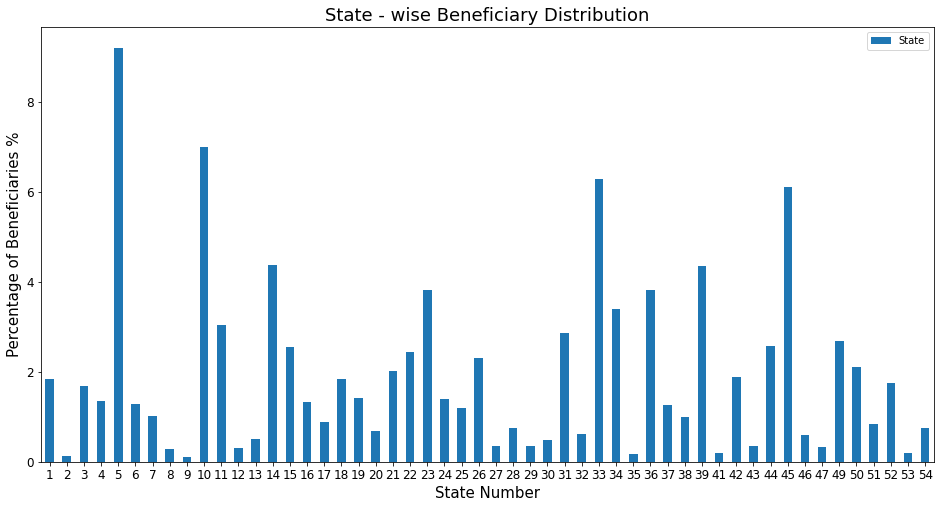

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#First, we want to see how distributed the beneficiaries are in our dataset
#PLotting the frequencies of Statewise beneficiaries
count_States = pd.value_counts(Train_Allprovider['State'], sort = False)

#Drawing a barplot
(count_States*100/len(Train_Allprovider)).plot(kind = 'bar', rot=0,figsize=(16,8),fontsize=12,legend=True)

#Giving titles and labels to the plot
plt.title("State - wise Beneficiary Distribution",fontsize=18)
plt.xlabel("State Number",fontsize=15)
plt.ylabel("Percentage of Beneficiaries "'%',fontsize=15)
plt.show()

plt.savefig('StateWiseBeneficiaryDistribution')

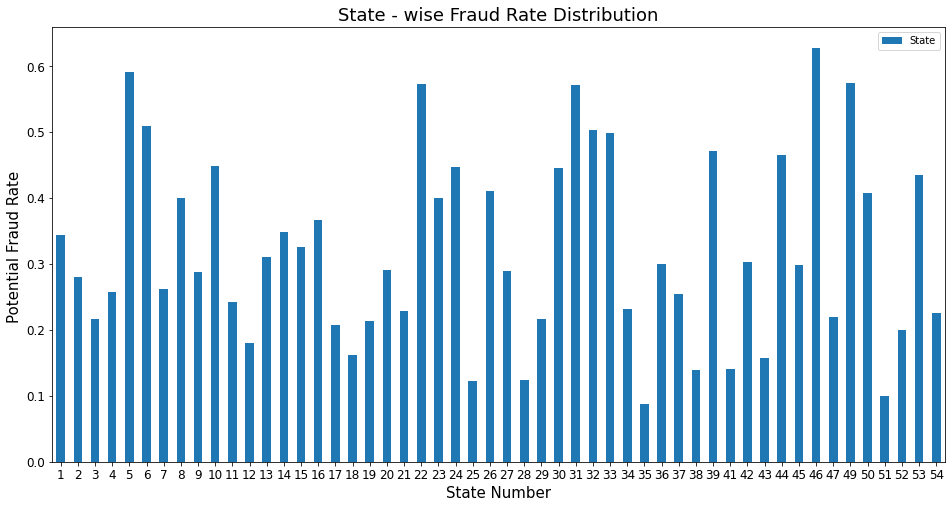

In [ ]:
#More important than this though is we want to see if the "fraud rates" vary with different states
count_States = pd.value_counts(Train_Allprovider['State'], sort = False)
Train_FraudOnly = Train_Allprovider[Train_Allprovider['PotentialFraud'] == 'Yes']
count_States_fraud = pd.value_counts(Train_FraudOnly['State'], sort = False)
count_States_fraud_rate = count_States_fraud/count_States
count_States_fraud_rate

#Drawing a barplot
(count_States_fraud_rate).plot(kind = 'bar', rot=0,figsize=(16,8),fontsize=12,legend=True)

plt.title("State - wise Fraud Rate Distribution",fontsize=18)
plt.xlabel("State Number",fontsize=15)
plt.ylabel("Potential Fraud Rate ",fontsize=15)
plt.show()

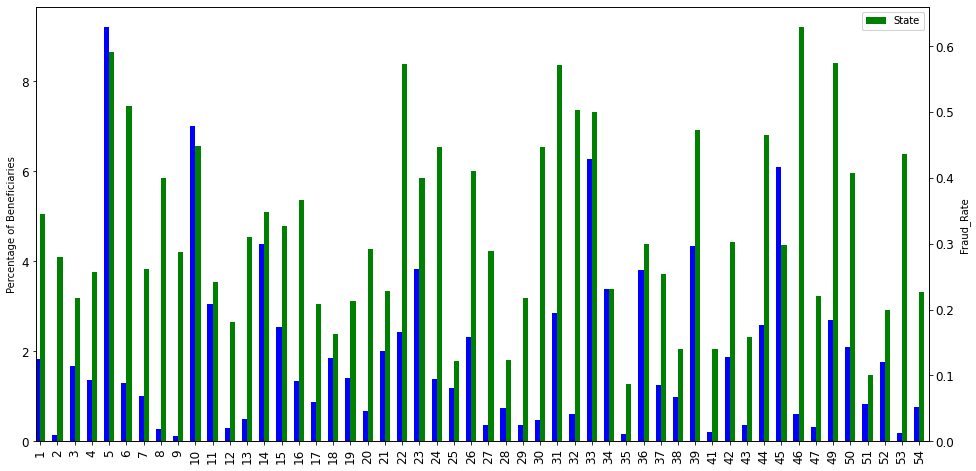

In [ ]:
#Want to combine the earlier two visualizations to have a better understanding of the state-fraud relationsh
#set up a new dataframe for simulatenous plotting

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_ylabel('Percentage of Beneficiaries')
ax2.set_ylabel('Fraud_Rate')


width=0.3

#df1=df1.set_index('6month').sort_index()
#df2=df2.set_index('6month').sort_index()

(count_States*100/len(Train_Allprovider)).plot(kind='bar',color='blue',figsize=(16,8),fontsize=12,legend=True, ax=ax1,width=width,position=1)
count_States_fraud_rate.plot(kind='bar',color='green',figsize=(16,8),fontsize=12,legend=True, ax=ax2,width=width,position=0)
plt.show()

Based on this visualization, there is no clear relationship between the number of beneficiaries in each state and the percentage of fraud in said state. In other words, it is reasonable to believe that fraudulent providers may concentrate their activities on certain vulnerable states (regardless of size)

####**Visualizing Relationship between Diagnosis Count and Fraud Rate**

In [ ]:
#need to drop duplicates for beneID so that we only get one row of data per beneficiary
Train_AllproviderUnique = Train_Allprovider.drop_duplicates(subset=['BeneID'], keep='last')
Train_FraudOnlyUnique = Train_FraudOnly.drop_duplicates(subset=['BeneID'], keep='last')

In [ ]:
diagnosis_df = Train_AllproviderUnique.groupby(['Diagnosis_count']).count().reset_index()
diagnosis_df = diagnosis_df[['Diagnosis_count', 'PotentialFraud']]
diagnosis_df_fraud = Train_FraudOnlyUnique.groupby(['Diagnosis_count']).count().reset_index()
diagnosis_df_fraud = diagnosis_df_fraud[['Diagnosis_count', 'PotentialFraud']]
result2 = pd.merge(diagnosis_df, diagnosis_df_fraud, how="left", on=["Diagnosis_count"])
result2['PotentialFraud_y'] = result2['PotentialFraud_y'].fillna(0)
result2 = result2.rename(columns={"PotentialFraud_x": "Beneficiaries_Count", "PotentialFraud_y": "Potential_Fraud_Count"})
result2['fraud_rate'] = result2['Potential_Fraud_Count']/result2['Beneficiaries_Count']
result2

,Diagnosis_count,Beneficiaries_Count,Potential_Fraud_Count,fraud_rate
0,0,2680,1461,0.545149
1,1,45893,25650,0.558909
2,2,28980,16527,0.570290
3,3,18812,10778,0.572932
4,4,12577,7331,0.582889
5,5,6988,4164,0.595879
6,6,4630,2886,0.623326
7,7,3328,2180,0.655048
8,8,2995,2271,0.758264
9,9,10143,9276,0.914522


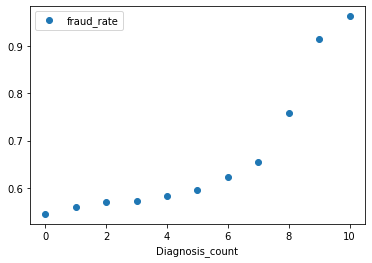

In [ ]:
result2.plot(x='Diagnosis_count', y='fraud_rate', style='o')

#### **The above visualization shows that there seems to be some sort of correlation between diagnosis count and fraud rate. The higher the diagnosis count, the higher the fraud rate.**


In [ ]:
import pandas as pd
Train=pd.read_csv("dataset/Train.csv")
Train_Beneficiarydata=pd.read_csv("dataset/Train_Beneficiarydata.csv")
Train_Inpatientdata=pd.read_csv("dataset/Train_Inpatientdata.csv")
Train_Outpatientdata=pd.read_csv("dataset/Train_Outpatientdata.csv")

In [ ]:
# Combine In and Out patients into one df
Train_Allpatientdata = pd.concat([Train_Inpatientdata, Train_Outpatientdata])
Train_Allpatientdata.sort_values('Provider', inplace=True)
Train_Allpatientdata.reset_index(drop=True, inplace=True)
#combine patients info with beneficiaries info
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, left_on='BeneID', right_on='BeneID', how='inner')
Train_Allpatientdata.sort_values('Provider', inplace=True)
Train_Allpatientdata.reset_index(drop=True, inplace=True)
#merge train data and train_beneficiary data
Train_Allprovider = pd.merge(Train, Train_Allpatientdata, on = 'Provider')

### Overview of the possible fraudulent claims:
The average cost of potential fraud claims and also what is the cost as a percentage of whole cost

295681120


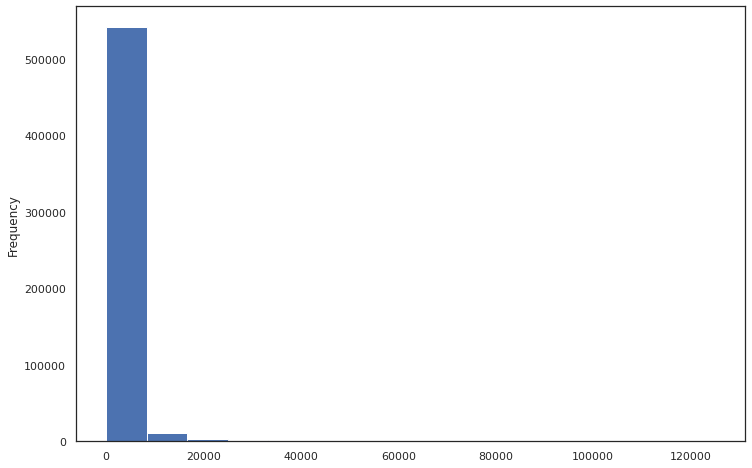

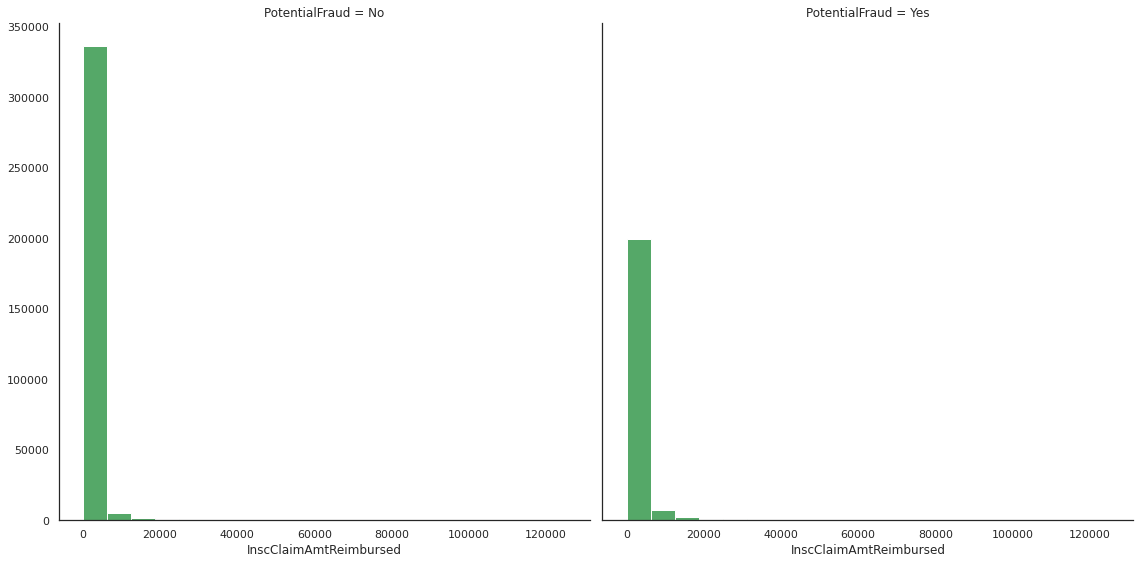

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cost=Train_Allprovider['InscClaimAmtReimbursed'].plot.hist(bins=15)
g = sns.FacetGrid(Train_Allprovider, col='PotentialFraud', height=8)
g.map(plt.hist, 'InscClaimAmtReimbursed', bins=20, color = 'g')
cost_fraud = Train_Allprovider.loc[(Train_Allprovider['PotentialFraud'] == 'Yes')]
Total = cost_fraud['InscClaimAmtReimbursed'].sum()
print(Total)

## Conclusion: There is significant cost that could be fradulent.
## The total potential fraud can be around $295681120,
## which would be a huge problem for the health insurance company.

## Basic data understanding

### 1, Race distribution of beneficiaries

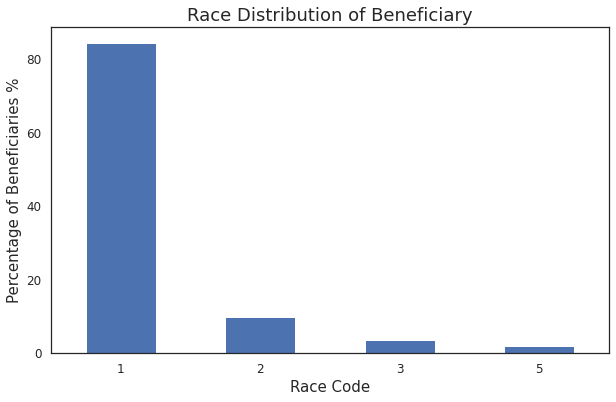

<Figure size 864x576 with 0 Axes>

In [ ]:
import numpy as np
#PLotting the frequencies of race-wise beneficiaries
count_Race = pd.value_counts(Train_Beneficiarydata['Race'], sort = True)

#Drawing a barplot
(count_Race*100/len(Train_Beneficiarydata)).plot(kind = 'bar', rot=0,figsize=(10,6),fontsize=12)

#Giving titles and labels to the plot
plt.yticks(np.arange(0,100,20))#, ('0 %','20 %', '40 %', '60 %', '80 %', '100%'))
plt.title("Race Distribution of Beneficiary",fontsize=18)
plt.xlabel("Race Code",fontsize=15)
plt.ylabel("Percentage of Beneficiaries "'%',fontsize=15)

plt.show()

plt.savefig('RaceBeneficiaryDistribution')

### Conclusion: more than 80% of all the beneficiaries come from the same race

In [ ]:
Train_Allprovider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         558211 non-null  object 
 1   PotentialFraud                   558211 non-null  object 
 2   BeneID                           558211 non-null  object 
 3   ClaimID                          558211 non-null  object 
 4   ClaimStartDt                     558211 non-null  object 
 5   ClaimEndDt                       558211 non-null  object 
 6   InscClaimAmtReimbursed           558211 non-null  int64  
 7   AttendingPhysician               556703 non-null  object 
 8   OperatingPhysician               114447 non-null  object 
 9   OtherPhysician                   199736 non-null  object 
 10  AdmissionDt                      40474 non-null   object 
 11  ClmAdmitDiagnosisCode            145899 non-null  object 
 12  De

### 2, Top-10 procedures in healthcare fraud

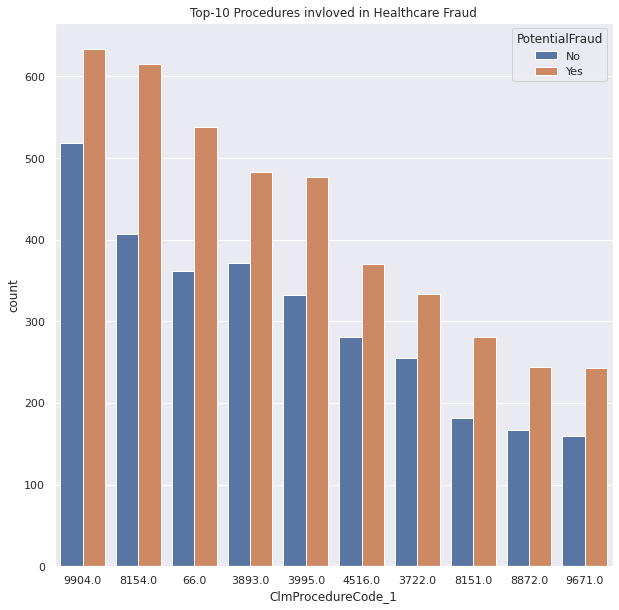

<Figure size 720x720 with 0 Axes>

In [ ]:
## Lets plot countplot for each fraud non fraud categories

sns.set(rc={'figure.figsize':(10,10)})

ax=sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=Train_Allprovider
              ,order=Train_Allprovider.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Procedures invloved in Healthcare Fraud')

plt.show()

plt.savefig('TopProceduresinvlovedinHealthcareFraud')

### From the above plot,we can say that Procedure 9904, 8154, 66 are top procedures (in terms of money involved).Distribution of fraud and non fraud count shows suspicious transactions involved in them.

### 3, explore features in non-fraud and fraud groups

a. IPAnnualDeductibleAmt Vs IPAnnualReimbursementAmt

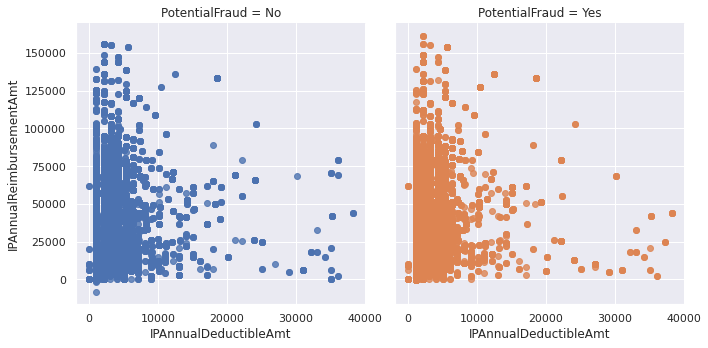

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

sns.lmplot(x='IPAnnualDeductibleAmt',y='IPAnnualReimbursementAmt',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_Allprovider)


#plt.title('IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories')

plt.savefig('IPAnnualDeductibleAmtandIPAnnualReimbursementAmtinbothfraudandnonFraud')

### Conclusion: No significant difference found in two amounts

b.DeductibleAmtPaid Vs InsClaimAmtReimbursed

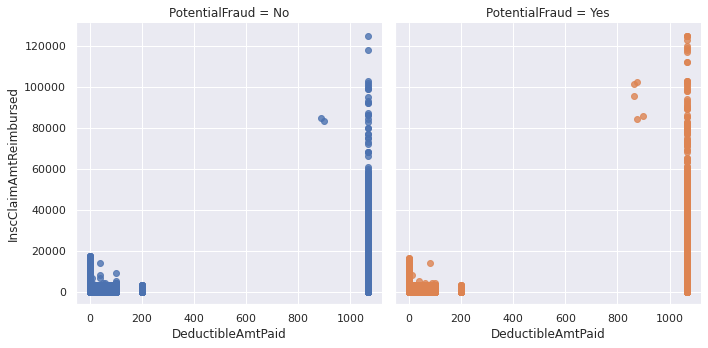

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

sns.lmplot(x='DeductibleAmtPaid',y='InscClaimAmtReimbursed',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_Allprovider)


plt.savefig('DeductibleAmtPaidandInsClaimAmtReimbursed')

Conclusion: no significance found

c. Insurance Claim Amount Reimbursed Vs Age

In [ ]:
Train_Allprovider['DOB'] = pd.to_datetime(Train_Allprovider['DOB'] , format = '%Y-%m-%d')
Train_Allprovider['DOD'] = pd.to_datetime(Train_Allprovider['DOD'],format = '%Y-%m-%d',errors='ignore')
Train_Allprovider['Age'] = round(((Train_Allprovider['DOD'] - Train_Allprovider['DOB']).dt.days)/365)

In [ ]:
Train_Allprovider.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Train_Allprovider['DOB']).dt.days)/365),
                                 inplace=True)

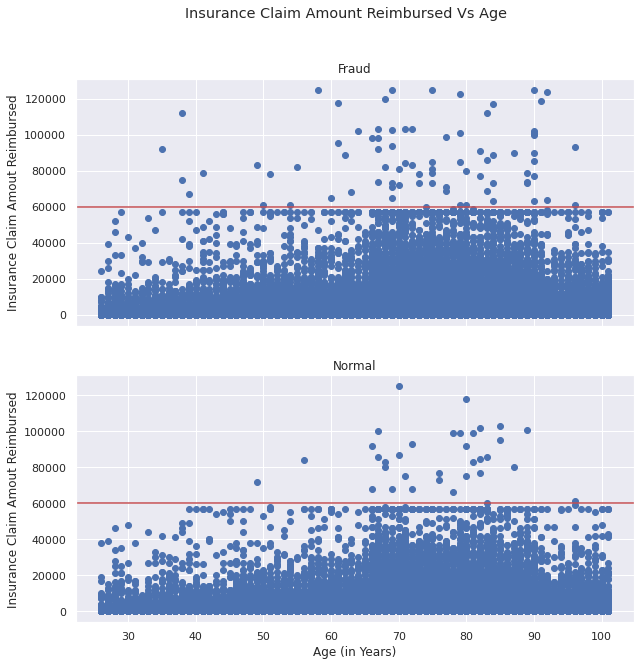

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Insurance Claim Amount Reimbursed Vs Age')

ax1.scatter(Train_Allprovider[Train_Allprovider.PotentialFraud=='Yes'].Age,
            Train_Allprovider[Train_Allprovider.PotentialFraud=='Yes'].InscClaimAmtReimbursed)
ax1.set_title('Fraud')
ax1.axhline(y=60000,c='r')
ax1.set_ylabel('Insurance Claim Amout Reimbursed')

ax2.scatter(Train_Allprovider[Train_Allprovider.PotentialFraud=='No'].Age,
            Train_Allprovider[Train_Allprovider.PotentialFraud=='No'].InscClaimAmtReimbursed)
ax2.set_title('Normal')
ax2.axhline(y=60000,c='r')
ax2.set_xlabel('Age (in Years)')
ax2.set_ylabel('Insurance Claim Amout Reimbursed')

plt.show()
f.savefig('AgeVsClaimAmtReimbursed')

conclusion: It's obvious to see from the graph that for age groups from 30 to 70, there are more fraudulent claims. Age could be one important feature for later modelling.


### Feature Engineering

In this step we need to do feature engineering for the further machine learning analysis. Feature engineering steps include: ensembling, one-hot encoding, converting, drop meaningless columns...

In [ ]:
# randomly pick two rows to observe features
Train_Allprovider.iloc[[1000,1001]]

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Diagnosis_count,Procedure_count,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
1000,PRV51005,Yes,BENE93153,CLM574555,2009-09-11,2009-09-11,20,NaN,0.0,3,0,1943-08-01,NaN,2,2,Y,25,290,12,12,2,1,1,2,1,1,1,1,1,2,2,7000,1068,1010,20
1001,PRV51005,Yes,BENE120767,CLM381231,2009-05-26,2009-05-26,40,7140,0.0,1,0,1971-09-01,NaN,1,1,0,1,620,12,12,2,2,2,2,2,1,2,1,2,1,2,0,0,2190,480


In [ ]:
# Create a feature 'ClaimProcessDt' = ClaimEndDt - ClaimStartDt
Train_Allprovider['ClaimStartDt'] = pd.to_datetime(Train_Allprovider['ClaimStartDt'])
Train_Allprovider['ClaimEndDt'] = pd.to_datetime(Train_Allprovider['ClaimEndDt'])
Train_Allprovider['ClaimProcessDt'] = Train_Allprovider['ClaimEndDt'] - Train_Allprovider['ClaimStartDt']
Train_Allprovider['ClaimProcessDt'] = Train_Allprovider['ClaimProcessDt'].dt.days
Train_Allprovider['ClaimProcessDt'].unique()

array([ 0,  1, 14,  4,  2,  5,  9, 20, 13, 11,  8,  6, 15,  3, 18,  7, 27,
       16, 12, 17, 19, 10, 28, 23, 24, 33, 25, 29, 35, 21, 22, 30, 26, 32,
       31, 34, 36])

In [ ]:
# Gender Race State Country
Train_Allprovider['Race'].unique()

array([1, 2, 5, 3])

In [ ]:
# Replacing Y with 1 for RenalDiseaseIndicator, that means RenalDisease No is 0 and yes is 1
# Replacing 2 with 0 for chronic conditions, that means chroniv condition No is 0 and yes is 1
Train_Allprovider["RenalDiseaseIndicator"].replace({'Y':1,"0":0}, inplace=True)
Train_Allprovider.replace({'ChronicCond_Alzheimer': 2,
       'ChronicCond_Heartfailure':2 , 'ChronicCond_KidneyDisease':2,
       'ChronicCond_Cancer':2 , 'ChronicCond_ObstrPulmonary':2,
       'ChronicCond_Depression':2, 'ChronicCond_Diabetes':2,
       'ChronicCond_IschemicHeart':2, 'ChronicCond_Osteoporasis':2,
       'ChronicCond_rheumatoidarthritis':2 , 'ChronicCond_stroke': 2 }, 0, inplace=True)

In [ ]:
# drop some columns
drop_columns = ['BeneID', 'ClmAdmitDiagnosisCode', 'ClaimID','ClaimStartDt',
       'ClaimEndDt', 'DOB', 'DOD','ClmAdmitDiagnosisCode','Gender','Race','State','County']
Train_Allprovider.drop(columns = drop_columns, inplace=True)
Train_Allprovider.shape

(558211, 25)

In [ ]:
print(Train_Allprovider['Diagnosis_count'].value_counts())
print(Train_Allprovider['Procedure_count'].value_counts())
print(Train_Allprovider['NoOfMonths_PartACov'].value_counts())
print(Train_Allprovider['NoOfMonths_PartBCov'].value_counts())
print(Train_Allprovider['ChronicCond_Alzheimer'].value_counts())
print(Train_Allprovider['ChronicCond_Heartfailure'].value_counts())
print(Train_Allprovider['IPAnnualReimbursementAmt'].value_counts())

1     185153
2     119550
3      78519
4      52612
9      36805
5      27532
6      18215
7      12733
8      11629
0      10453
10      5010
Name: Diagnosis_count, dtype: int64
0    534901
1     17820
2      4521
3       851
4       109
5         9
Name: Procedure_count, dtype: int64
12    554722
0       2971
6        116
8        100
11        81
4         55
7         44
10        34
5         30
3         16
2         16
9         13
1         13
Name: NoOfMonths_PartACov, dtype: int64
12    553918
0       1979
6        728
10       402
11       313
9        242
8        142
7        139
5        126
3         73
4         60
1         48
2         41
Name: NoOfMonths_PartBCov, dtype: int64
0    333884
1    224327
Name: ChronicCond_Alzheimer, dtype: int64
1    329583
0    228628
Name: ChronicCond_Heartfailure, dtype: int64
0         371676
4000        9909
5000        8822
3000        8301
6000        7506
           ...  
23500          1
57510          1
31050          1
2110   

In [ ]:
Train_Allprovider.iloc[[1000,1001]]

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Diagnosis_count,Procedure_count,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimProcessDt
1000,PRV51005,Yes,20,0.0,3,0,1,12,12,0,1,1,0,1,1,1,1,1,0,0,7000,1068,1010,20,0
1001,PRV51005,Yes,40,0.0,1,0,0,12,12,0,0,0,0,0,1,0,1,0,1,0,0,0,2190,480,0


### Machine Learning

1. First Aggregate claims data to unique providers.



In [ ]:
Train_All_groupbyProv = Train_Allprovider.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
Train_All_groupbyProv

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Diagnosis_count,Procedure_count,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimProcessDt
0,PRV51001,No,104640,5340.0,80,3,8,300,300,15,19,17,5,10,9,21,23,6,8,6,440150,22428,65380,11598,36
1,PRV51003,Yes,605670,66286.0,693,48,29,1560,1567,56,80,64,10,41,54,100,112,33,38,12,999000,122948,353520,97300,485
2,PRV51004,No,52170,310.0,385,0,23,1768,1782,64,88,50,16,41,63,105,108,49,46,17,648430,64808,327040,92790,213
3,PRV51005,Yes,280910,3700.0,3016,0,259,13872,13910,426,680,507,165,295,485,799,895,344,331,124,4221950,441724,2457840,741323,1268
4,PRV51007,No,33710,3264.0,215,1,11,852,852,26,40,22,12,16,29,49,51,21,22,12,219600,32040,124540,33820,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,10640,130.0,58,0,5,336,336,14,20,15,4,11,9,20,28,13,9,4,110940,12816,90770,24830,60
5406,PRV57760,No,4770,0.0,52,0,0,264,258,3,11,2,0,2,7,18,22,11,1,0,61280,9612,32840,17720,7
5407,PRV57761,No,18470,370.0,219,0,23,984,984,36,56,40,14,30,38,55,62,32,24,10,576180,48060,240130,58000,114
5408,PRV57762,No,1900,0.0,1,0,0,12,12,0,0,1,1,1,0,1,1,0,0,0,15000,1068,2540,400,0


In [ ]:
Train_All_groupbyProv['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

2. Then do the scaling(standardization) of all the numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

#The code below makes a column transformer object that scales the two non-categorical columns
# and one hot encodes the three categorical columns
preprocess = make_column_transformer(
    (StandardScaler(),['InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'Diagnosis_count', 'Procedure_count',
       'RenalDiseaseIndicator', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimProcessDt'], )
)

#The next step prepares the independent variables
X_scaled = preprocess.fit_transform(Train_All_groupbyProv)

print(X_scaled.shape)
print(X_scaled)

(5410, 23)
[[ 0.00657567 -0.10988379 -0.30299113 ... -0.26768656 -0.30586834
  -0.33051582]
 [ 1.87113809  2.3355533   0.50220615 ...  0.18685442  0.16696905
   0.71242766]
 [-0.18868926 -0.31171079  0.09763721 ...  0.14508221  0.14208635
   0.08062225]
 ...
 [-0.31410242 -0.30930331 -0.12040969 ...  0.00798164 -0.04985797
  -0.14933633]
 [-0.37576699 -0.32414943 -0.40676043 ... -0.36681669 -0.36765025
  -0.41413712]
 [-0.22054495 -0.30850082 -0.01532685 ...  0.2078825   0.15312081
   0.05739411]]


3. train test split

    (convert target label "PotentialFraud" to 1 if "Yes" else 0)


In [ ]:
from sklearn.model_selection import train_test_split

y = Train_All_groupbyProv['PotentialFraud'].map({"Yes":1,"No":0})

x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(3787, 23) (3787,)
(1623, 23) (1623,)


In [ ]:
print(y.value_counts()) # print target label

0    4904
1     506
Name: PotentialFraud, dtype: int64


In [ ]:
4904/(506+4904)

0.9064695009242144

#### Model 1: Logistic Regression

##### 1.1 Basic Model

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv=10,class_weight='balanced',random_state=42)

# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
#in the input data as ``n_samples / (n_classes * np.bincount(y))``.

log.fit(x_train,y_train)

In [ ]:
#get training and testing data accuracy
train_acc_log = log.score(x_train,y_train)
test_acc_log = log.score(x_test,y_test)

print("training accuracy: ",train_acc_log)
print("testing accuracy: ",test_acc_log)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_log = log.predict(x_test)

#Get confusion matrix
cfm_log = confusion_matrix(y_test, test_pred_log)
print(cfm_log)

#Get f1 score, precision and recall
f1_log = f1_score(y_test, test_pred_log)
precision_log = precision_score(y_test,test_pred_log)
recall_log = recall_score(y_test,test_pred_log)

print("precision: ",precision_log)
print("recall: ",recall_log)
print("f1 score: ",f1_log)

training accuracy:  0.9022973329812517
testing accuracy:  0.9063462723351817
confusion matrix:
[[1368   96]
 [  56  103]]
precision:  0.5175879396984925
recall:  0.6477987421383647
f1 score:  0.5754189944134078


####Model 2: Stochastic Gradient Descent

##### 2.1 Basic Model

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42,max_iter=1000)
sgd.fit(x_train,y_train)

SGDClassifier(random_state=42)

In [ ]:
#get training and testing data accuracy
train_acc_sgd = sgd.score(x_train,y_train)
test_acc_sgd = sgd.score(x_test,y_test)

print("training accuracy: ",train_acc_sgd)
print("testing accuracy: ",test_acc_sgd)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_sgd = sgd.predict(x_test)

#Get confusion matrix
cfm_sgd = confusion_matrix(y_test, test_pred_sgd)
print(cfm_sgd)

#Get f1 score, precision and recall
f1_sgd = f1_score(y_test, test_pred_sgd)
precision_sgd = precision_score(y_test,test_pred_sgd)
recall_sgd = recall_score(y_test,test_pred_sgd)

print("precision: ",precision_sgd)
print("recall: ",recall_sgd)
print("f1 score: ",f1_sgd)

training accuracy:  0.8389226300501716
testing accuracy:  0.8311768330252619
confusion matrix:
[[1245  219]
 [  55  104]]
precision:  0.3219814241486068
recall:  0.6540880503144654
f1 score:  0.43153526970954353


#####2.2 Gridsearch SGD
Tune hyperparameters using grid search

In [ ]:
import datetime as datetime
start = datetime.datetime.now()
print(start)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [.00001,.0001,.001],
    'l1_ratio': [0.01, 1], #Ideally, we should vary this in small increments between 0 and 1!
    'class_weight': [{1:5},{1:9},{1:10},{1:15}]
}
clf = SGDClassifier(random_state=42)

clf_grid = GridSearchCV(estimator=clf, cv=5, param_grid=param_grid,
                                    n_jobs=-1, scoring="f1")

clf_grid.fit(X=x_train, y=y_train)

end = datetime.datetime.now()
print(end)
duration = end - start



2021-12-13 20:04:05.766105
2021-12-13 20:04:09.880521


In [ ]:
clf_grid.best_params_

{'alpha': 0.001,
 'class_weight': {1: 5},
 'l1_ratio': 1,
 'loss': 'log',
 'penalty': 'elasticnet'}

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd2 = SGDClassifier(random_state=42,alpha = 0.001,class_weight= {1: 5},l1_ratio= 1, loss='log', penalty= 'elasticnet')
sgd2.fit(x_train,y_train)

#get training and testing data accuracy
train_acc_sgd2 = sgd2.score(x_train,y_train)
test_acc_sgd2 = sgd2.score(x_test,y_test)

print("training accuracy: ",train_acc_sgd2)
print("testing accuracy: ",test_acc_sgd2)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_sgd2 = sgd2.predict(x_test)

#Get confusion matrix
cfm_sgd2 = confusion_matrix(y_test, test_pred_sgd2)
print(cfm_sgd2)

#Get f1 score, precision and recall
f1_sgd2 = f1_score(y_test, test_pred_sgd2)
precision_sgd2 = precision_score(y_test,test_pred_sgd2)
recall_sgd2 = recall_score(y_test,test_pred_sgd2)

print("precision: ",precision_sgd2)
print("recall: ",recall_sgd2)
print("f1 score: ",f1_sgd2)

training accuracy:  0.923950356482704
testing accuracy:  0.9192852741836106
confusion matrix:
[[1393   71]
 [  60   99]]
precision:  0.5823529411764706
recall:  0.6226415094339622
f1 score:  0.601823708206687


####Model 3: Random Forest

##### 3.1 Basic Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Parameterize the random forest model and fit the data
rfc = RandomForestClassifier(random_state=42,n_estimators=30,max_depth=6,min_samples_leaf=200,min_samples_split=400)
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=200, min_samples_split=400,
                       n_estimators=30, random_state=42)

In [ ]:
#get training and testing data accuracy
train_acc_rfc = rfc.score(x_train,y_train)
test_acc_rfc = rfc.score(x_test,y_test)

print("training accuracy: ",train_acc_rfc)
print("testing accuracy: ",test_acc_rfc)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_rfc = rfc.predict(x_test)

#Get confusion matrix
cfm_rfc = confusion_matrix(y_test, test_pred_rfc)
print(cfm_rfc)

#Get f1 score, precision and recall
f1_rfc = f1_score(y_test, test_pred_rfc)
precision_rfc = precision_score(y_test,test_pred_rfc)
recall_rfc = recall_score(y_test,test_pred_rfc)

print("precision: ",precision_rfc)
print("recall: ",recall_rfc)
print("f1 score: ",f1_rfc)

training accuracy:  0.9263269078426195
testing accuracy:  0.9229821318545902
confusion matrix:
[[1451   13]
 [ 112   47]]
precision:  0.7833333333333333
recall:  0.29559748427672955
f1 score:  0.4292237442922374


<span style="color:green;font-size:x-large">Interpreting the results of the Random Forest Classifier</span>
<li>The confusion matrix reports 0 false positives and 0 true positives</li>
<li>The model is predicting that everything is a negative because that gives a pretty good accuracy</li>
<p></p>
<span style="color:green;font-size:x-large">What's going on?</span>
<li>Since the data is imbalanced (about 91% negative and 9% positive), the best model predicts everything is negative</li>
<li>And it is right 91% of the time</li>
<li>Quite pointless. We don't need complicated ML models to get this result!</li>
<li>Let's look at a different measure, the f1 score</li>

$$ recall = \frac{tp}{(tp + fn)} $$

$$ precision = \frac{tp}{(tp + fp)} $$

$$ F = 2\frac{precision * recall}{(precision + recall)} $$



<li>precision is zero because the number of positives found is 0 (numerator is 0)- actually both the numerator as well as the denominator are 0 so it defaults to </li>
<li>recall is zero because the number of positives found is 0 (numerator is 0) 0</li>
<li>therefore the f1 score is also 0</li>

<span style="color:green;font-size:x-large">Perhaps, instead of focusing on accuracy, we should be focusing on maximizing the f1 score</span>

##### 3.2 Balanced Random Forest Classifier
Use class weights to correct the positive negative imbalance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Parameterize the random forest model and fit the data
rfc2 = RandomForestClassifier(random_state=42,n_estimators=30,max_depth=6,min_samples_leaf=200,min_samples_split=400,class_weight={1:9})
rfc2.fit(x_train,y_train)

#get training and testing data accuracy
train_acc_rfc2 = rfc2.score(x_train,y_train)
test_acc_rfc2 = rfc2.score(x_test,y_test)

print("training accuracy: ",train_acc_rfc2)
print("testing accuracy: ",test_acc_rfc2)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_rfc2 = rfc2.predict(x_test)

#Get confusion matrix
cfm_rfc2 = confusion_matrix(y_test, test_pred_rfc2)
print(cfm_rfc2)

#Get f1 score, precision and recall
f1_rfc2 = f1_score(y_test, test_pred_rfc2)
precision_rfc2 = precision_score(y_test,test_pred_rfc2)
recall_rfc2 = recall_score(y_test,test_pred_rfc2)

print("precision: ",precision_rfc2)
print("recall: ",recall_rfc2)
print("f1 score: ",f1_rfc2)

training accuracy:  0.8434116715077898
testing accuracy:  0.8422674060382008
confusion matrix:
[[1230  234]
 [  22  137]]
precision:  0.3692722371967655
recall:  0.8616352201257862
f1 score:  0.5169811320754717


#####3.3 Gridserach Random Forest Classifier
Tune hyperparameters using grid search

In [ ]:
# only need to run once and build model with the best parameters
import datetime
start = datetime.datetime.now()
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score,make_scorer
parameters = {
     'n_estimators':( 100,200,400), #the number of trees
     'min_samples_split': (100, 200, 400),
     'max_depth': (5,6,7,8,9,10),
    'class_weight': [{1:9},{1:5}],
     'min_samples_leaf': (50,100,200)
}
#https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
#scorer = {'avg_precision': make_scorer(average_precision_score)}
gs_clf = GridSearchCV(RandomForestClassifier(random_state=42),parameters,cv=5,n_jobs=-1,
                      scoring='f1')
#                     scoring=make_scorer(average_precision_score))
gs_clf.fit(x_train, np.ravel(y_train))
end = datetime.datetime.now()

In [ ]:
gs_clf.best_params_

{'class_weight': {1: 5},
 'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 200}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Parameterize the random forest model and fit the data
rfc3 = RandomForestClassifier(random_state=42,n_estimators=200,max_depth=5,min_samples_leaf=50,min_samples_split=100,class_weight={1:5})
rfc3.fit(x_train,y_train)

#get training and testing data accuracy
train_acc_rfc3 = rfc3.score(x_train,y_train)
test_acc_rfc3 = rfc3.score(x_test,y_test)

print("training accuracy: ",train_acc_rfc3)
print("testing accuracy: ",test_acc_rfc3)
print("confusion matrix:")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

#Get testing predictions
test_pred_rfc3 = rfc3.predict(x_test)

#Get confusion matrix
cfm_rfc3 = confusion_matrix(y_test, test_pred_rfc3)
print(cfm_rfc3)

#Get f1 score, precision and recall
f1_rfc3 = f1_score(y_test, test_pred_rfc3)
precision_rfc3 = precision_score(y_test,test_pred_rfc3)
recall_rfc3 = recall_score(y_test,test_pred_rfc3)

print("precision: ",precision_rfc3)
print("recall: ",recall_rfc3)
print("f1 score: ",f1_rfc3)

training accuracy:  0.9062582519144442
testing accuracy:  0.9081947011706716
confusion matrix:
[[1355  109]
 [  40  119]]
precision:  0.5219298245614035
recall:  0.7484276729559748
f1 score:  0.6149870801033591


### Model Evaluation

#### ROC Curve

In [ ]:
import bokeh
bokeh.__version__

'2.3.3'

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot

In [ ]:
output_notebook()

In [ ]:
#Draw a single ROC curve for one model
#Include the AUC
#Include the random chance line
#Include gridlines to see values

def draw_one_roc_curve(fpr,tpr,thresholds,auc,model):
    #Set up the ColumnDataSource object
    from bokeh.models import LabelSet, ColumnDataSource,HoverTool
    import pandas as pd
    df_d = pd.DataFrame([fpr,tpr,thresholds]).transpose()
    df_d.columns = ["fpr","tpr","threshold"]
    source = ColumnDataSource(df_d)


    # Create custom HoverTool -- we'll make one for each curve
    hover_ROC = HoverTool(names=['ROC'], tooltips=[("TPR", "@tpr"),
                                                   ("FPR", "@fpr"),
                                                   ("Thresh", "@threshold"),
                                                  ])

    # Create the tools
    p_tools_ROC = [hover_ROC, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    p1 = figure(title="ROC Curve for "+model, tools=p_tools_ROC,x_range=(0,1),y_range=(0,1))

    p1.xaxis.axis_label = 'False Positive Rate'
    p1.yaxis.axis_label = 'True Positive Rate'

    # plot curve and datapts
    p1.line('fpr', 'tpr', line_width=1, color="blue", source=source)
    p1.circle('fpr', 'tpr', size=3, color="orange", legend_label='auc='+auc, source=source, name='ROC')

    # Plot chance (tpr = fpr 45 degrees line)
    p1.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Keep the legend at the bottom
    p1.legend.location = "bottom_right"

    #Return the figure
    return p1


def draw_roc_curves():

    #Get the predicted probabilities for each model
    #Note that we can't just use predictions because they will be 0,1 values
    from sklearn.model_selection import cross_val_predict
    predic_prob_model_1 = cross_val_predict(log,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_2 = cross_val_predict(sgd,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_3 = cross_val_predict(sgd2,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_4 = rfc.predict_proba(x_test)
    predic_prob_model_5 = rfc2.predict_proba(x_test)
    predic_prob_model_6 = rfc3.predict_proba(x_test)

    #Get the AUC for each model
    from sklearn.metrics import roc_curve, roc_auc_score
    auc_m1 = roc_auc_score(y_test,predic_prob_model_1)
    auc_m2 = roc_auc_score(y_test,predic_prob_model_2)
    auc_m3 = roc_auc_score(y_test,predic_prob_model_3)
    auc_m4 = roc_auc_score(y_test,predic_prob_model_4[:,1])
    auc_m5 = roc_auc_score(y_test,predic_prob_model_5[:,1])
    auc_m6 = roc_auc_score(y_test,predic_prob_model_6[:,1])

    #Format auc to two decimal places
    auc_m1 = "%1.2f"%auc_m1
    auc_m2 = "%1.2f"%auc_m2
    auc_m3 = "%1.2f"%auc_m3
    auc_m4 = "%1.2f"%auc_m4
    auc_m5 = "%1.2f"%auc_m5
    auc_m6 = "%1.2f"%auc_m6

    #Using the predicted probabilities, get the roc curves
    #fpr = false positive rate
    #tpr = true positive rate
    #thresholds = threshold choices
    #The ROC curve reports the fpr and tpr for each chosen threshold
    fpr_m1,tpr_m1,thresholds_m1 = roc_curve(y_test,predic_prob_model_1)
    fpr_m2,tpr_m2,thresholds_m2 = roc_curve(y_test,predic_prob_model_2)
    fpr_m3,tpr_m3,thresholds_m3 = roc_curve(y_test,predic_prob_model_3)
    fpr_m4,tpr_m4,thresholds_m4 = roc_curve(y_test,predic_prob_model_4[:,1])
    fpr_m5,tpr_m5,thresholds_m5 = roc_curve(y_test,predic_prob_model_5[:,1])
    fpr_m6,tpr_m6,thresholds_m6 = roc_curve(y_test,predic_prob_model_6[:,1])

    #Draw the various ROC Curves
    p1=draw_one_roc_curve(fpr_m1,tpr_m1,thresholds_m1,auc_m1,"Naive Logisitc Model")
    p2=draw_one_roc_curve(fpr_m2,tpr_m2,thresholds_m2,auc_m2,"Naive SGD Model")
    p3=draw_one_roc_curve(fpr_m3,tpr_m3,thresholds_m3,auc_m3,"GridSearch SGD Model")
    p4=draw_one_roc_curve(fpr_m4,tpr_m4,thresholds_m4,auc_m4,"Naive Random ForestModel")
    p5=draw_one_roc_curve(fpr_m5,tpr_m5,thresholds_m5,auc_m5,"Balanced Random Forest Model")
    p6=draw_one_roc_curve(fpr_m6,tpr_m6,thresholds_m6,auc_m6,"GridSearch Random ForestModel")

    #Set up the grid for all the curves
    grid = gridplot([[p1,p2],[p3,p4],[p5,p6]],sizing_mode="scale_both",merge_tools=True)

    #Show the curves
    show(grid)

#Call the function
draw_roc_curves()

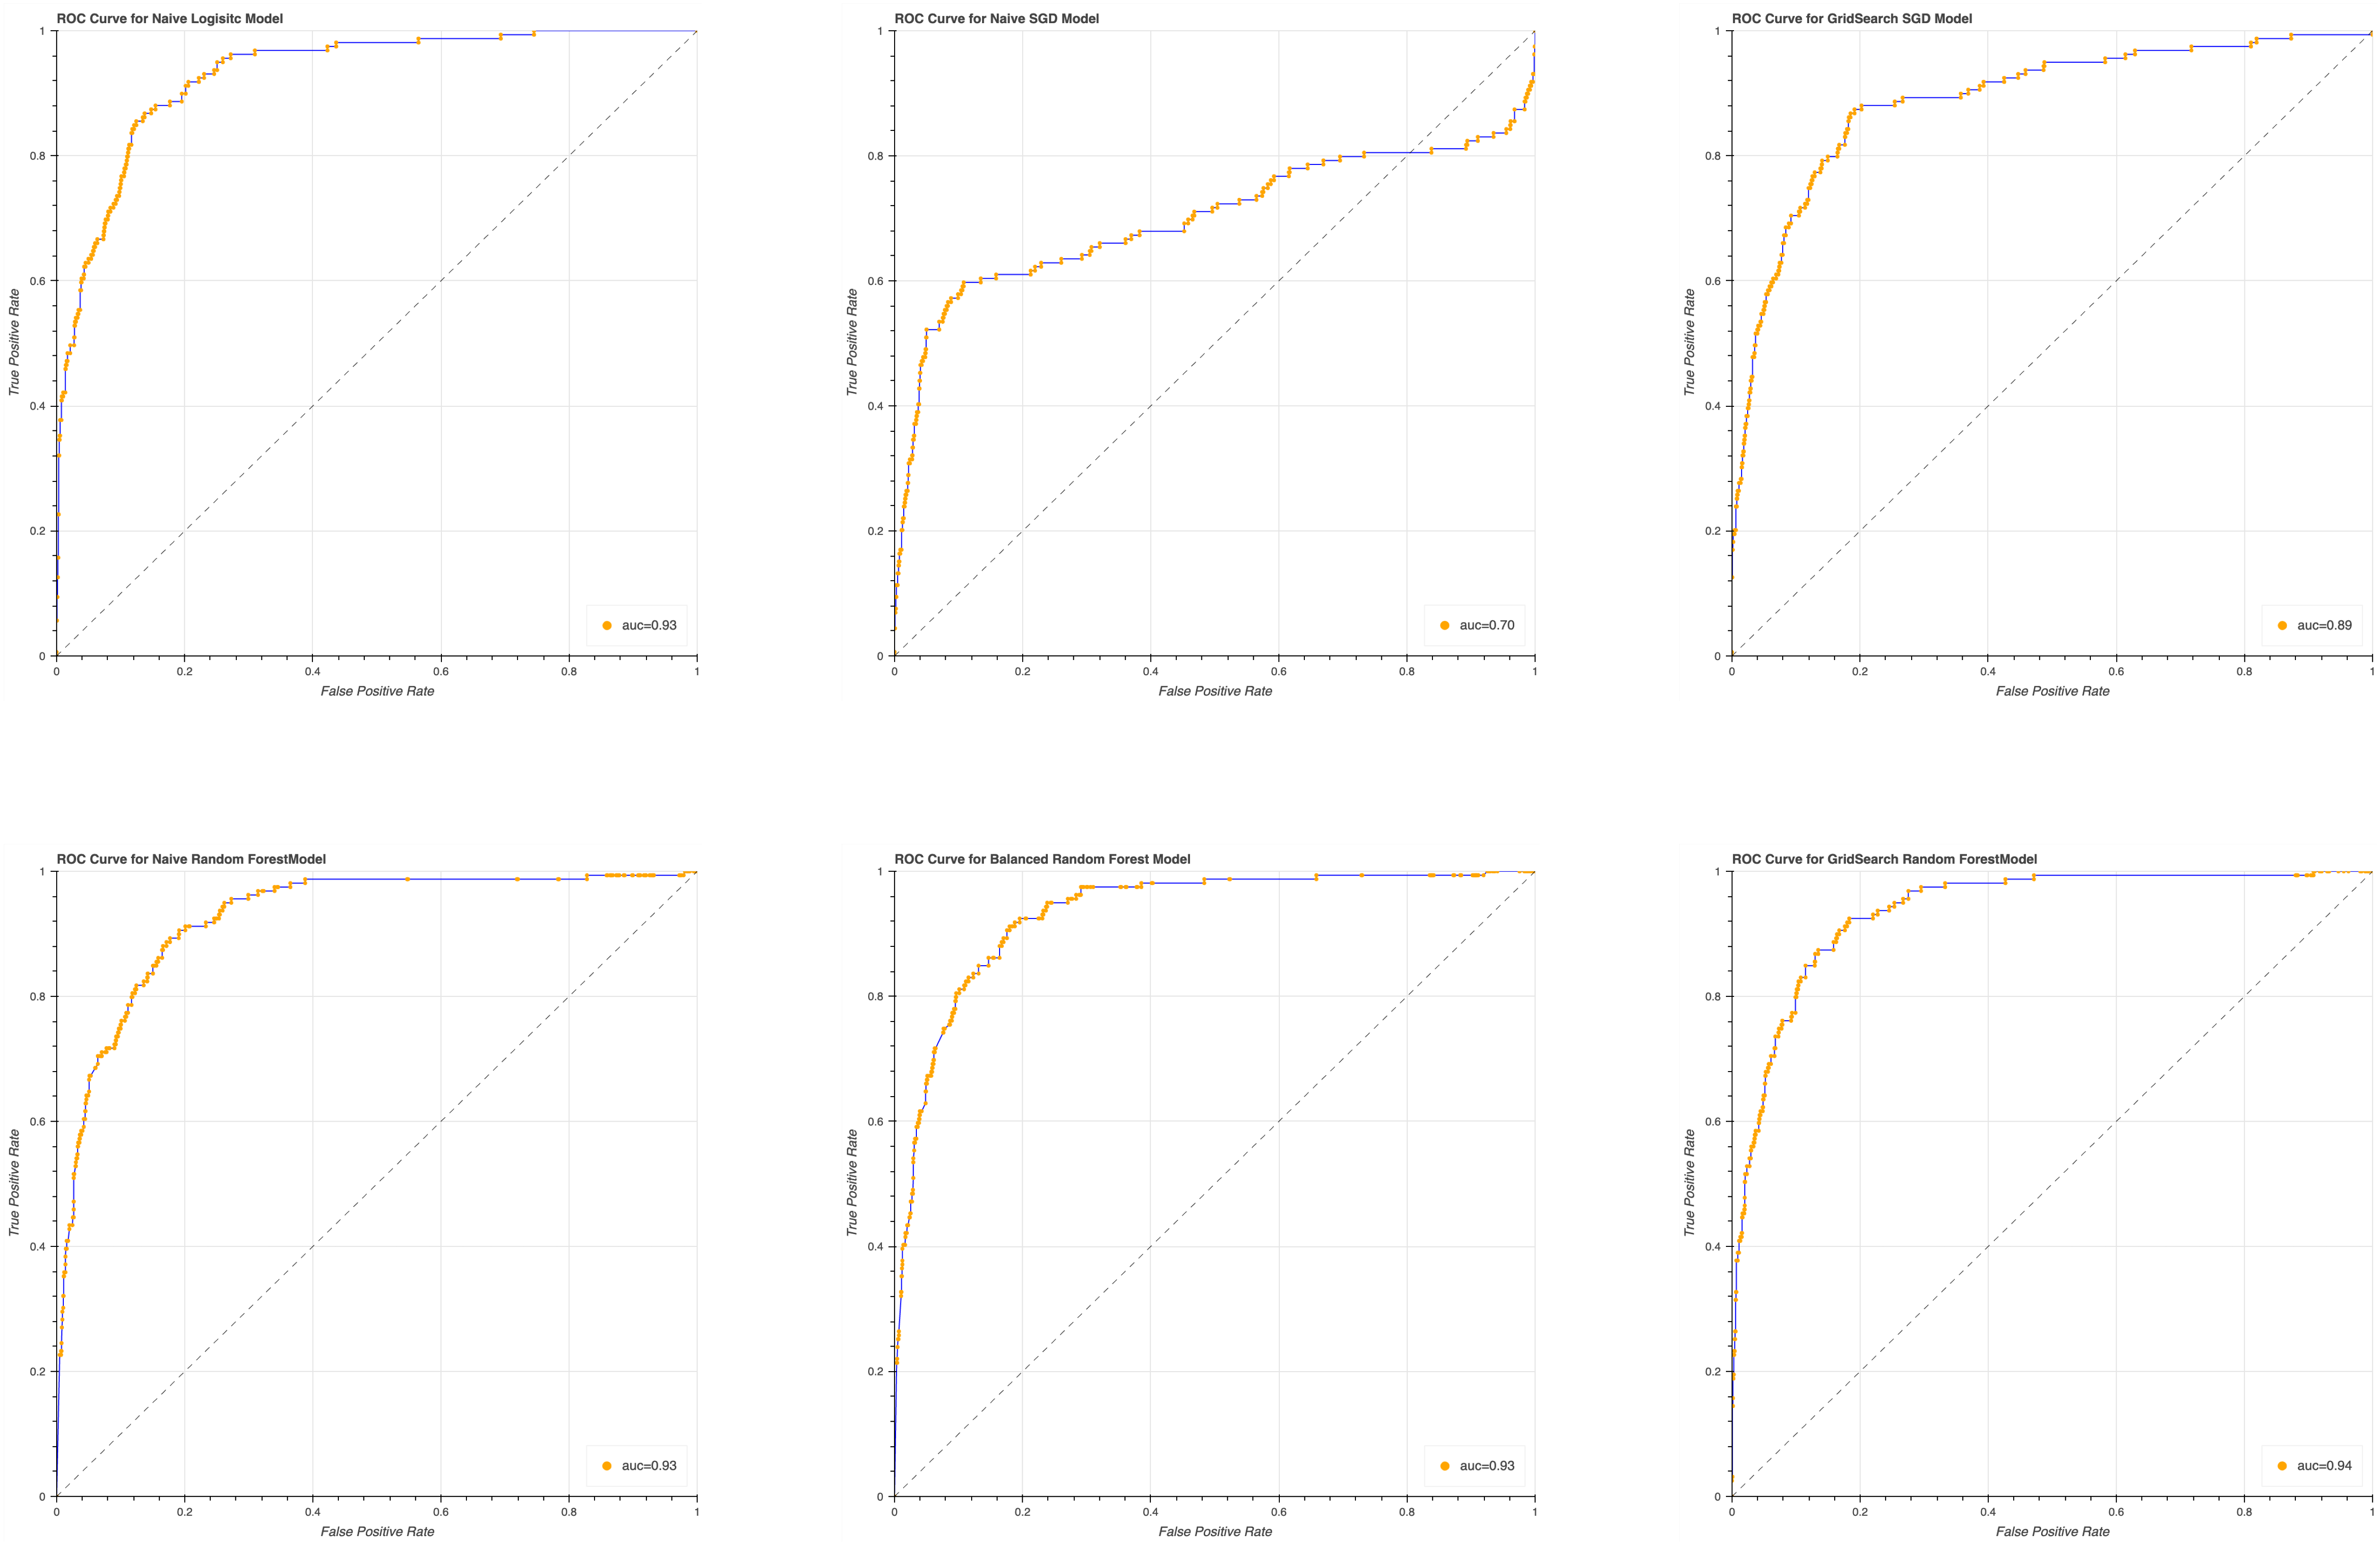

In [ ]:
roc1 = plt.imread('roc_1.png')
roc2 = plt.imread('roc_2.png')
roc3 = plt.imread('roc_3.png')
roc4 = plt.imread('roc_4.png')
roc5 = plt.imread('roc_5.png')
roc6 = plt.imread('roc_6.png')
images = [roc1, roc2, roc3, roc4, roc5, roc6]

NUM_ROWS = 2
IMGs_IN_ROW = 3

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(90,60))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.set_axis_off()
        ax.imshow(images[j*IMGs_IN_ROW+i])

plt.show()


In [ ]:
def draw_one_PR_curve(precision,recall,thresholds,f1_score ,model):
    from bokeh.models import LabelSet, ColumnDataSource, Label
    import pandas as pd

    df_d = pd.DataFrame([recall,precision,thresholds]).transpose()
    df_d.columns = ["recall","precision","threshold"]

    source = ColumnDataSource(df_d)

    p_tools = ['crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    #Figure
    p = figure(title="PR Curve for "+model, tools=p_tools)
    p.xaxis.axis_label = 'threshold'
    p.yaxis.axis_label = 'precision/recall'

    #Add lines for precision and recall
    p.line('threshold', 'precision', line_width=1, color="blue", source=source,legend_label="precision")
    p.line('threshold', 'recall', line_width=1, color="red", source=source,legend_label="recall")

    f1_label = Label(x=1.0, y=.70, x_units='screen', y_units='screen', text='F1 Score='+f1_score, render_mode='css',
      border_line_color='black', border_line_alpha=0.0,
      background_fill_color='white', background_fill_alpha=1.0)

    p.add_layout(f1_label)

    # legend location
    p.legend.location = "bottom_left"
    return p

def draw_pr_curves():
    #Get the predicted probabilities for each model
    #Note that we can't just use predictions because they will be 0,1 values
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import precision_recall_curve

    predic_prob_model_1 = cross_val_predict(log,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_2 = cross_val_predict(sgd,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_3 = cross_val_predict(sgd2,x_test,y_test,cv=5,method="decision_function")
    predic_prob_model_4 = rfc.predict_proba(x_test)
    predic_prob_model_5 = rfc2.predict_proba(x_test)
    predic_prob_model_6 = rfc3.predict_proba(x_test)

    #Get precisions and recalls
    precision_1,recall_1,thresholds_1 = precision_recall_curve(y_test,predic_prob_model_1)
    precision_2,recall_2,thresholds_2 = precision_recall_curve(y_test,predic_prob_model_2)
    precision_3,recall_3,thresholds_3 = precision_recall_curve(y_test,predic_prob_model_3)
    precision_4,recall_4,thresholds_4 = precision_recall_curve(y_test,predic_prob_model_4[:,1])
    precision_5,recall_5,thresholds_5 = precision_recall_curve(y_test,predic_prob_model_5[:,1])
    precision_6,recall_6,thresholds_6 = precision_recall_curve(y_test,predic_prob_model_6[:,1])

    #draw the curves
    p1 = draw_one_PR_curve(precision_1,recall_1,thresholds_1,str("%1.2f"%f1_log),"Naive Logisitc Model")
    p2 = draw_one_PR_curve(precision_2,recall_2,thresholds_2,str("%1.2f"%f1_sgd),"Naive SGD Model")
    p3 = draw_one_PR_curve(precision_3,recall_3,thresholds_3,str("%1.2f"%f1_sgd2),"GridSearch SGD Model")
    p4 = draw_one_PR_curve(precision_4,recall_4,thresholds_4,str("%1.2f"%f1_rfc),"Naive Random ForestModel")
    p5 = draw_one_PR_curve(precision_5,recall_5,thresholds_5,str("%1.2f"%f1_rfc2),"Balanced Random Forest Model")
    p6 = draw_one_PR_curve(precision_6,recall_6,thresholds_6,str("%1.2f"%f1_rfc3),"GridSearch Random ForestModel")

    #Set up the grid for all the curves
    grid = gridplot([[p1,p2],[p3,p4],[p5,p6]],sizing_mode="scale_both",merge_tools=True)

    #Show the curves
    show(grid)

draw_pr_curves()



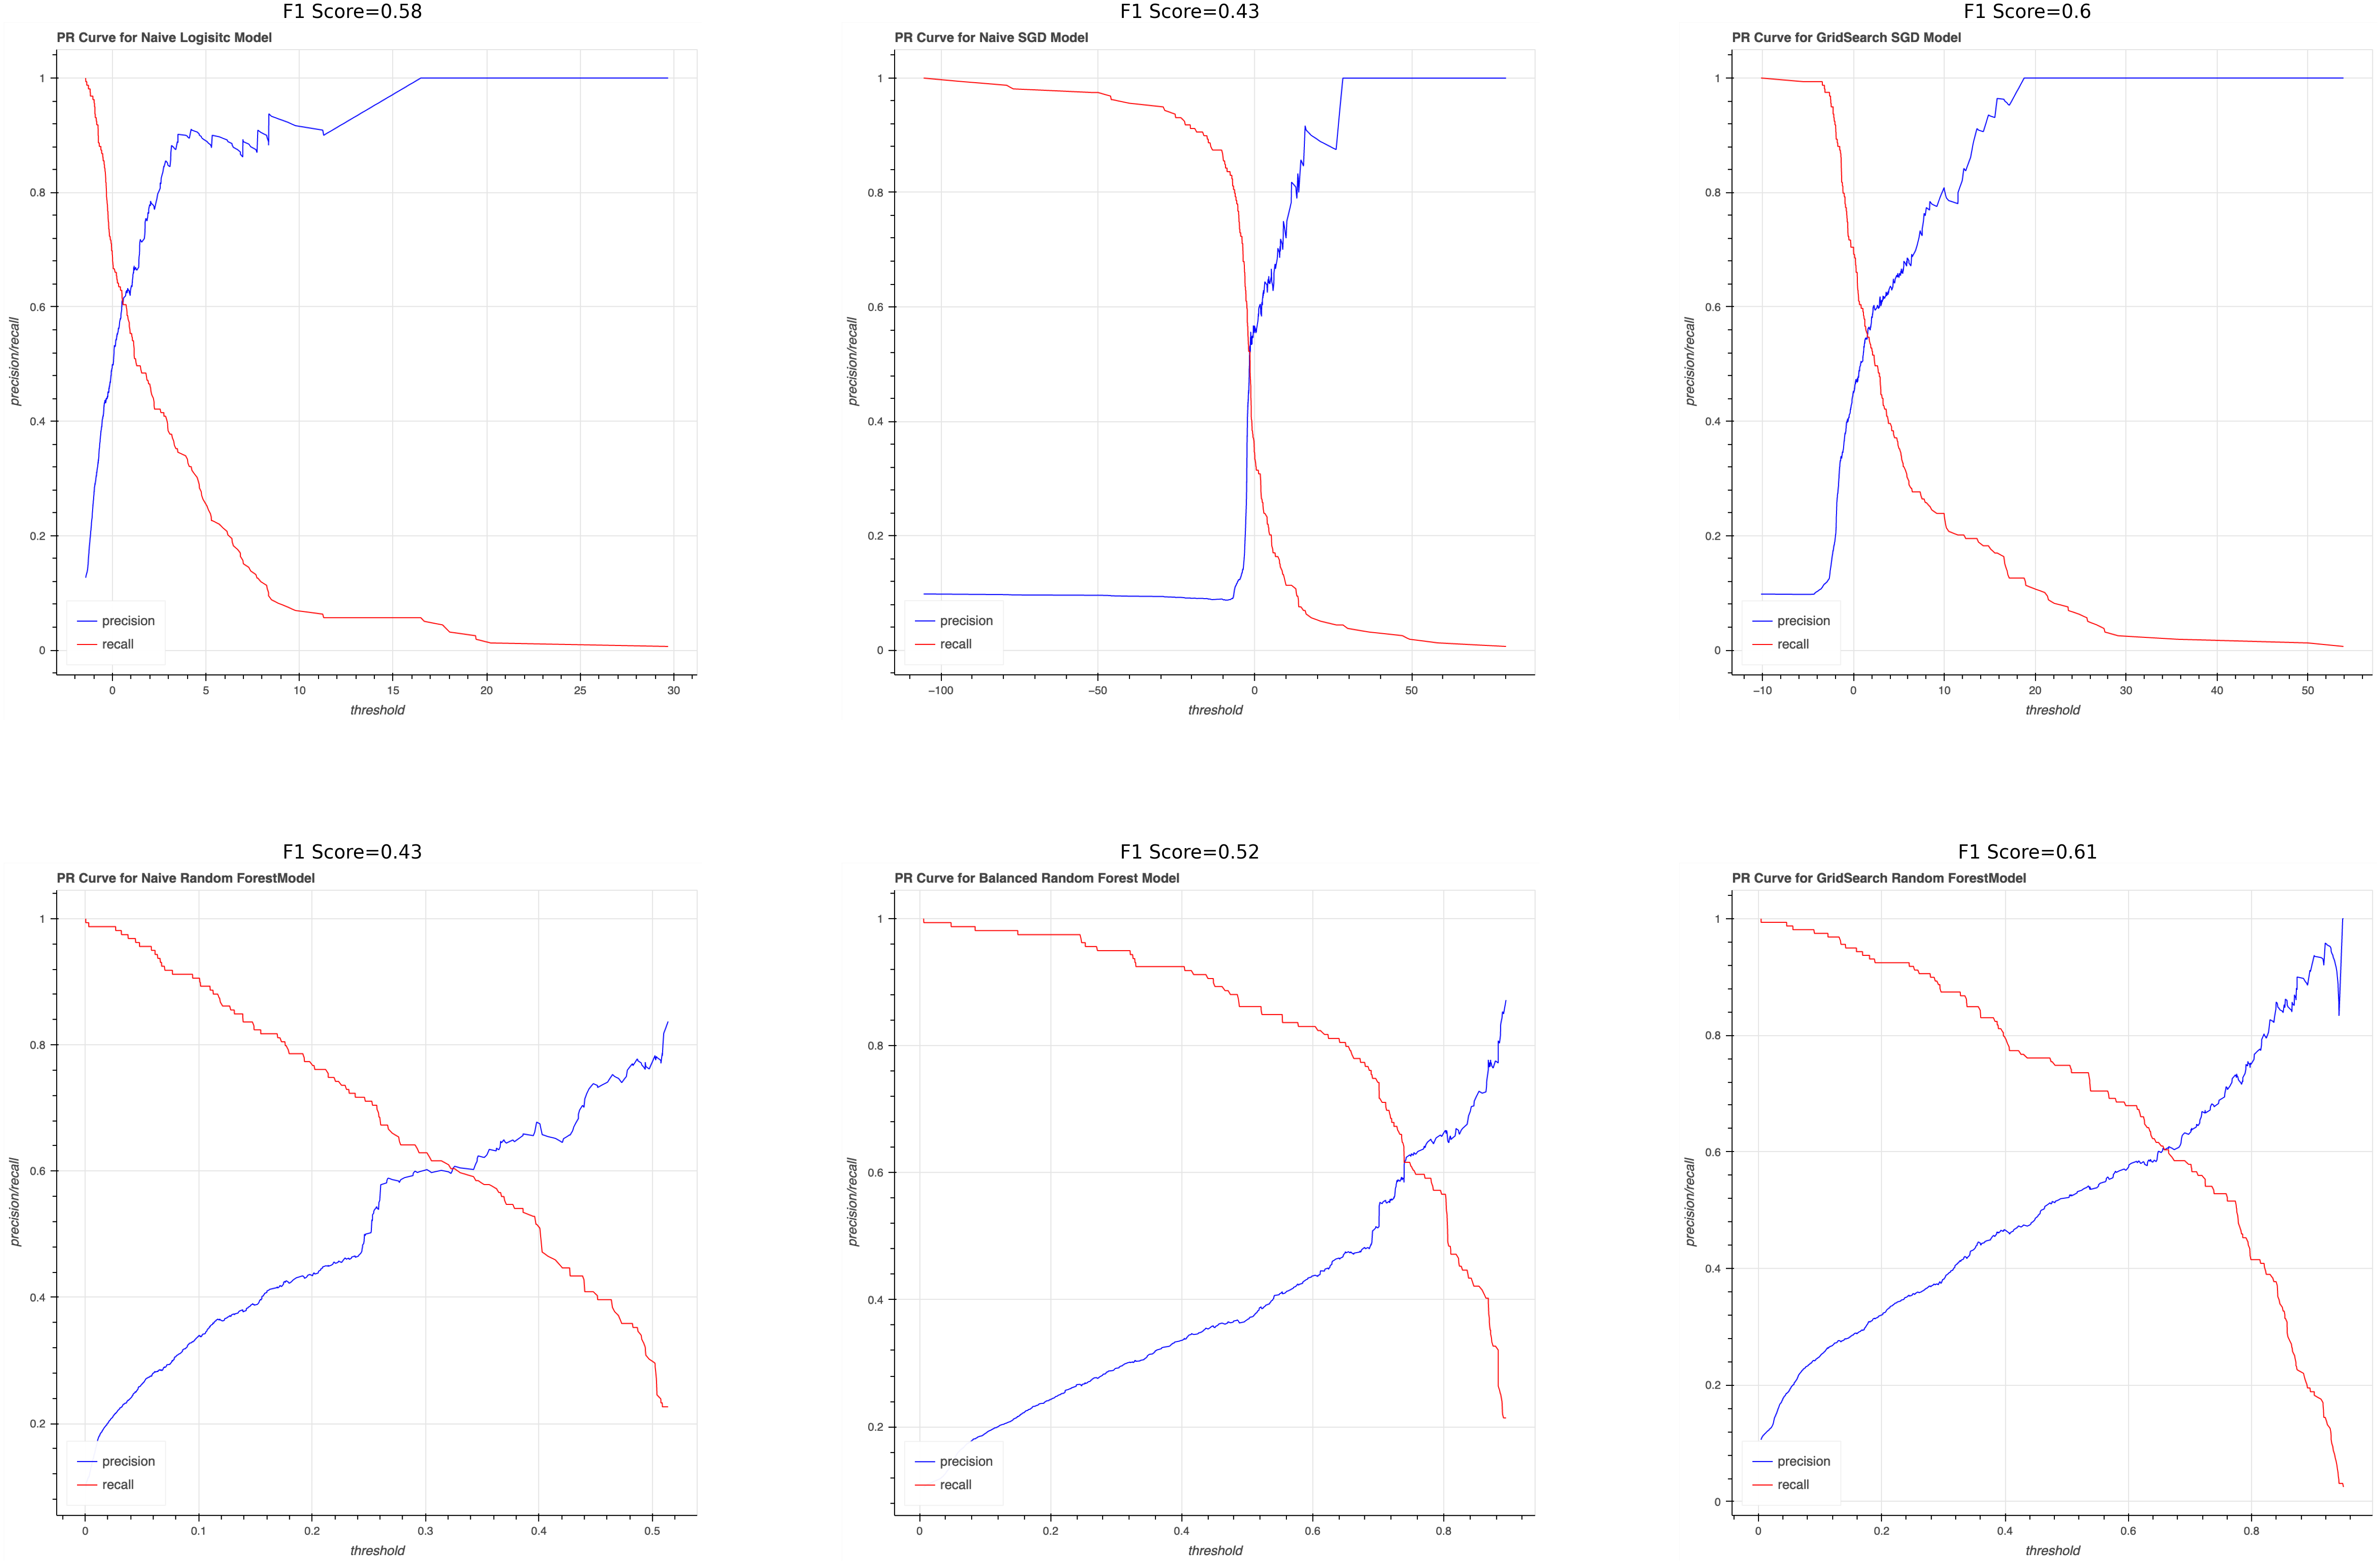

In [ ]:
pr1 = plt.imread('pr_1.png')
pr2 = plt.imread('pr_2.png')
pr3 = plt.imread('pr_3.png')
pr4 = plt.imread('pr_4.png')
pr5 = plt.imread('pr_5.png')
pr6 = plt.imread('pr_6.png')
images = [pr1, pr2, pr3, pr4, pr5, pr6]
f1_score = [0.58, 0.43, 0.60, 0.43, 0.52, 0.61]

NUM_ROWS = 2
IMGs_IN_ROW = 3

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(90,60))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.set_axis_off()
        ax.imshow(images[j*IMGs_IN_ROW+i])
        ax.set_title('F1 Score=' + str(f1_score[j*IMGs_IN_ROW+i]), fontsize=40)

plt.show()
